In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_vggface.vggface import VGGFace
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import RMSprop, Adam
import keras_metrics
import pandas
import ast


Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
train_set = ".\\dataset\\train"
validation_set = ".\\dataset\\val"
test_set = ".\\dataset\\test"

In [5]:
from keras.preprocessing.image import load_img, ImageDataGenerator

In [6]:
train_df = pandas.read_csv(".\\dataset\\train\\output_final.csv")
valid_df = pandas.read_csv(".\\dataset\\val\\output_final.csv")
test_df = pandas.read_csv(".\\dataset\\test\\output_final.csv")

In [7]:
train_datagen = ImageDataGenerator(
    brightness_range=[0.4,1.0], 
    featurewise_center = True,
    featurewise_std_normalization = True, 
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='.\\dataset\\train',
        x_col="filename",
        y_col=["x_start","y_start","width","height"],
        class_mode="raw",
        shuffle=True,
        target_size=(300, 300),
        batch_size=32)

valid_generator = train_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='.\\dataset\\val',
        x_col="filename",
        y_col=["x_start","y_start","width","height"],
        class_mode="raw",
        shuffle=True,
        target_size=(300, 300),
        batch_size=32)

Found 10806 validated image filenames.
Found 2403 validated image filenames.


In [8]:
step_size_train = train_generator.n/train_generator.batch_size
step_size_valid = valid_generator.n/valid_generator.batch_size

In [9]:
vgg_model = VGGFace(model='vgg16', include_top=False, weights='vggface', pooling='avg', input_shape=(300, 300, 3))

In [10]:
vgg_model.trainable = True

In [11]:
vgg_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 150, 150, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 75, 75, 128)     

In [12]:
count_conv_layer = 0
print("Vgg layers n°:",len(vgg_model.layers))
window_layers_size = 5
count_layer = 0
for layer in vgg_model.layers: #train only  convolutional layers in the last 50 layers 
    count_layer = count_layer +1
    if (count_layer >= (len(vgg_model.layers)-window_layers_size)) and ("conv" in layer.name):
        count_conv_layer = count_conv_layer + 1 
        layer.trainable = True
    else: 
        layer.trainable = False
print("Conv layers in the last",window_layers_size,"layers: ", count_conv_layer)

Vgg layers n°: 20
Conv layers in the last 5 layers:  3


In [13]:
vgg_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 150, 150, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 75, 75, 128)     

In [14]:
# define last layer output size
input_model_shape = vgg_model.input_shape[1]
output_global_pooling_size = vgg_model.output_shape[1]

In [15]:
# Rule 1 to choose neurons in hidden layers
rule_1_neurons_number = int((output_global_pooling_size + 4)/2)
# Rule 2 to choose neurons in hidden layers
rule_2_neurons_number = int(output_global_pooling_size/2) + 4
# Rule 2 to choose neurons in hidden layers
alpha = 2
rule_3_neurons_number = int(train_generator.n/(alpha*(4+output_global_pooling_size)))
number_of_hidden_layer = 3
rule_4_neurons_number = [int(round(x/(i+1),0)) for (x,i) in zip([output_global_pooling_size]*number_of_hidden_layer,
                                           range(number_of_hidden_layer))]

In [16]:
model = Sequential()
model.add(vgg_model)

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(rule_4_neurons_number[2],activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(4,activation='relu'))

In [17]:
model.compile(optimizer=Adam(), loss='mse', metrics=[keras_metrics.precision(), keras_metrics.recall()])

tracking <tf.Variable 'Variable:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_1:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn


In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 16388     
Total params: 33,613,636
Trainable params: 25,978,372
Non-trainable params: 7,635,264
__________________________________

In [19]:
model.evaluate_generator(valid_generator, steps=step_size_valid)

[12507.69140625, 86.48326110839844, 0.02022179402410984]

In [20]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
mcp_save = ModelCheckpoint('vggface.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, mode='min')

history = model.fit_generator(generator=train_generator, epochs=50, steps_per_epoch=step_size_train, validation_data=valid_generator, validation_steps=step_size_valid, verbose=2, callbacks=[mcp_save, earlyStopping, reduce_lr_loss])

Epoch 1/50
 - 70s - loss: 8358.0723 - precision: 103.9880 - recall: 66.9390 - val_loss: 2446.5332 - val_precision: 103.4105 - val_recall: 102.0000
Epoch 2/50
 - 69s - loss: 2474.4451 - precision: 103.3142 - recall: 102.5699 - val_loss: 2709.9990 - val_precision: 101.6081 - val_recall: 103.0000
Epoch 3/50
 - 69s - loss: 2475.1750 - precision: 103.6253 - recall: 102.9679 - val_loss: 2109.1765 - val_precision: 102.8983 - val_recall: 104.0000
Epoch 4/50
 - 69s - loss: 2472.7396 - precision: 103.7877 - recall: 103.4120 - val_loss: 2912.4299 - val_precision: 104.3731 - val_recall: 104.0000
Epoch 5/50
 - 69s - loss: 2468.6393 - precision: 103.1375 - recall: 102.7687 - val_loss: 3056.5481 - val_precision: 102.4070 - val_recall: 106.0000
Epoch 6/50
 - 69s - loss: 2467.3088 - precision: 103.4458 - recall: 102.8497 - val_loss: 655.6948 - val_precision: 104.1997 - val_recall: 103.0000
Epoch 7/50
 - 69s - loss: 2463.3962 - precision: 103.7533 - recall: 102.8782 - val_loss: 1575.3561 - val_precision

In [21]:
print(history.history)

{'val_loss': [2446.533203125, 2709.9990234375, 2109.176513671875, 2912.429931640625, 3056.548095703125, 655.69482421875, 1575.3560791015625, 1779.8563232421875, 4536.02490234375, 1161.2275390625, 3198.357177734375, 5775.28271484375, 3561.693359375, 1915.1668701171875, 2050.791748046875, 3362.030517578125, 2665.494873046875, 2013.0128173828125, 2249.5126953125, 1169.710205078125, 3290.580810546875], 'val_precision': [103.41046142578125, 101.60807037353516, 102.8983154296875, 104.37309265136719, 102.4069595336914, 104.19972229003906, 102.4977035522461, 103.55654907226562, 101.64139556884766, 103.30465698242188, 102.32416534423828, 104.64408874511719, 102.40521240234375, 103.4590835571289, 103.16943359375, 102.94654083251953, 103.4087905883789, 102.89822387695312, 103.41270446777344, 103.0955810546875, 104.20559692382812], 'val_recall': [102.0, 103.0, 104.0, 104.0, 106.0, 103.0, 102.0, 101.0, 101.0, 106.0, 103.0, 102.0, 104.0, 102.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0], 'loss

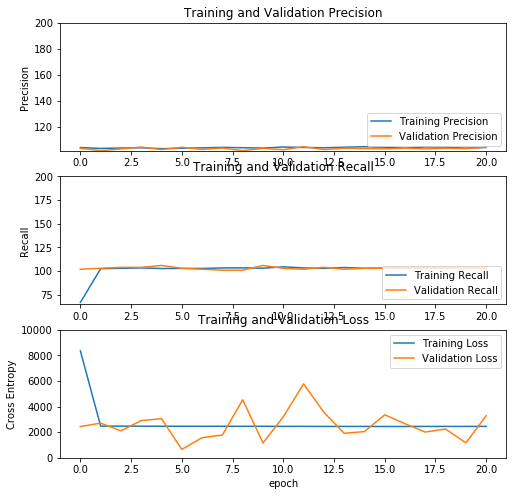

{'val_loss': [2446.533203125, 2709.9990234375, 2109.176513671875, 2912.429931640625, 3056.548095703125, 655.69482421875, 1575.3560791015625, 1779.8563232421875, 4536.02490234375, 1161.2275390625, 3198.357177734375, 5775.28271484375, 3561.693359375, 1915.1668701171875, 2050.791748046875, 3362.030517578125, 2665.494873046875, 2013.0128173828125, 2249.5126953125, 1169.710205078125, 3290.580810546875], 'val_precision': [103.41046142578125, 101.60807037353516, 102.8983154296875, 104.37309265136719, 102.4069595336914, 104.19972229003906, 102.4977035522461, 103.55654907226562, 101.64139556884766, 103.30465698242188, 102.32416534423828, 104.64408874511719, 102.40521240234375, 103.4590835571289, 103.16943359375, 102.94654083251953, 103.4087905883789, 102.89822387695312, 103.41270446777344, 103.0955810546875, 104.20559692382812], 'val_recall': [102.0, 103.0, 104.0, 104.0, 106.0, 103.0, 102.0, 101.0, 101.0, 106.0, 103.0, 102.0, 104.0, 102.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0, 103.0], 'loss

In [26]:
acc = history.history['precision']
val_acc = history.history['val_precision']

rec = history.history['recall']
val_rec = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Precision')
plt.plot(val_acc, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),200])
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(rec, label='Training Recall')
plt.plot(val_rec, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),200])
plt.title('Training and Validation Recall')

plt.subplot(3, 1, 3)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10000])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# In[ ]:


print(history.history)

In [ ]:
# In[ ]:

import pandas as pd
dict_data = history.history
df = pd.DataFrame.from_dict(dict_data, dtype=float)
csv_file = "history_resnet.csv"
df.to_csv(csv_file)


# In[ ]:

model_json = model.to_json()
with open("resnet50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

In [23]:
train_datagen = ImageDataGenerator(
    brightness_range=[0.4,1.0], 
    preprocessing_function=preprocess_input)

test_generator = train_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='.\\dataset\\test',
        x_col="filename",
        y_col=["x_start","y_start","width","height"],
        class_mode="raw",
        target_size=(300, 300),
        batch_size=128)

step_size_test = test_generator.n/test_generator.batch_size

Found 3366 validated image filenames.


In [24]:
import numpy as np

In [25]:
predictions = model.predict_generator(test_generator, step_size_test, verbose=1)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[128,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node vggface_vgg16/conv1_2/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[dense_3/Relu/_547]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[128,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node vggface_vgg16/conv1_2/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
print(predictions)

In [ ]:
from PIL import Image, ImageDraw
i = 0

for el in zip(predictions, test_generator.filenames):
    print(el[0], el[1])
    image = Image.open(test_generator.directory + "\\" + el[1])
    draw = ImageDraw.Draw(image)
    draw.rectangle(((el[0][0], el[0][1]), (el[0][0] + el[0][2], el[0][1] + el[0][3])), outline="Red")
    
    image.save('.\\dataset\\test_valuated\\' + el[1])    